In [436]:
import gzip, json, re
from collections import defaultdict, Counter
from os import listdir
import sys
import pylab as plt
import matplotlib.cm as cm
import numpy as np
import random
from datetime import datetime
import statsmodels.api as sm
import time
from copy import deepcopy
from itertools import groupby
import itertools
import networkx as nx
from sklearn import manifold
import gensim
from scipy import spatial
import matplotlib as mpl
%matplotlib inline

def flushPrint(www):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % www)
    sys.stdout.flush()


# Data preparation

### 1. Identify core members

In [437]:
# learn team members from contribution data

W=defaultdict(lambda:defaultdict(lambda:0))#n of contributions
#X=defaultdict(lambda:defaultdict(lambda:0))#last contributing time
#N={}
n=0
with open('/Users/lingfeiw/Documents/bigdata/Github_Small/PushEvent.csv', "rb") as f:
    for line in f:
        n+=1
        if n%1000000==0:
            flushPrint(n/1000000)#138
        line= line.strip().split(',')
        if len(line)==3:
            actor,repo,date=line
        if len(line)==5:
            actor,repo,date,pushSize,realSize=line
        actor=int(actor)
        repo=int(repo)
        date=date[:10]
        W[repo][actor]+=1
        #if date>X[repo][actor]:
            #X[repo][actor]=date
            
# identify core contributors
C={}
n=0
for i in W:
    n+=1
    if n%1000000==0:
        flushPrint(n/1000000)#9
    ms=np.mean(W[i].values())
    C[i]=[k for k,v in W[i].items() if v>=ms]

9

### 2. Construct (programming language) skill vectors of users

In [8]:
# calculate project popularity
U={}
with open('/Users/lingfeiw/Documents/bigdata/Github_Small/CreateEvent.csv', "rb") as f:
    for line in f:
        actor,repo,date=line.strip().split(',')
        repo=int(repo)
        U[repo]=int(actor)
        
n=0
P=defaultdict(lambda:0)
with open('/Users/lingfeiw/Documents/bigdata/Github_Small/ForkEvent.csv', "rb") as f:
    for line in f:
        n+=1
        if n%1000000==0:
            flushPrint(n/1000000)
        line= line.strip().split(',')
        actor,repo,date=line
        repo=int(repo)
        if repo in U and actor!=U[repo]:#remove self citation
            P[repo]+=1
P=dict(P)

9

In [371]:
# project language
L={}
f = open('/Users/lingfeiw/Documents/bigdata/Github_Small/Repo_final.txt', "rb")
for line in f:
    repoID, repoName, language, teamSize, NofPushes, repoFinalSize = line.strip().split('\t')
    if language!='0':
        L[int(repoID)]=language

In [49]:
n=0
S=defaultdict(lambda:defaultdict(lambda:[0,0]))# total contributed projects, successful contributed projects, 
for i in C:
    n+=1
    if n%1000000==0:
        flushPrint(n/1000000)#9
    if i in L and L[i]!='0':
        users=C[i]
        lan=L[i]
        for u in users:
            S[u][lan][0]+=1
        if i in P:#ever cited
            for u in users:
                S[u][lan][1]+=1
S=dict(S)# freeze
for i in S.keys():
    S[i]=dict(S[i])

9

### 3. skill vectors of two-(core)-members teams and success-and-failure labeling

In [372]:
Z=defaultdict(lambda:0)
for i in L:
    Z[L[i]]+=1
topAll=zip(*sorted(Z.iteritems(), key=lambda (k,v): (-v,k)))[0]
top20=zip(*sorted(Z.iteritems(), key=lambda (k,v): (-v,k)))[0][:20]

In [27]:
# take all cited, two-member teams 
C2={}
for i in C:
    if len(C[i])==2 and i in P:
        C2[i]=C[i]

In [405]:
def createSkilVector(sklldic):
    v=[]
    for i in top20:
        if i in sklldic:
            a,b=sklldic[i]
            v.append(b/float(a))
        else:
            v.append(0)
    return v

# project vector
V={}
for k in C2:
    team=C2[k]
    if len([u for u in team if u in S])==2:# all users have skill vectors
        vs=[]
        for u in C2[k]:
            sklldic=S[u]
            vs.append(createSkilVector(sklldic))
        V[k]=np.array(vs).T
#project label
Y={}
for i in V:
    if P[i]>=3:
        Y[i]=1#success
    else:
        Y[i]=0# fail

### 4. train skill vectors to predict success and fail

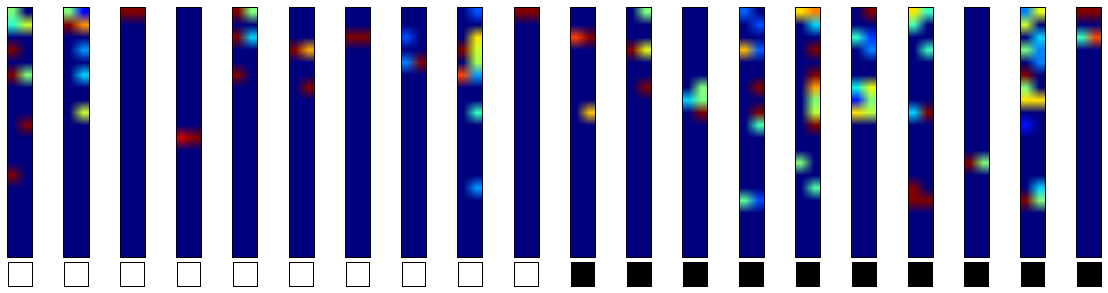

In [406]:
fig = plt.figure(figsize=(20, 5))
s=[7733259,3407887,8388628,7077911,8519705,7602204,4194309,131107,1966117,
 3014698,131077,9,9043981,16,22,4800973,32,786491,4718654,1966149]
for i in range(40):
    if i <20:
        axi = plt.subplot2grid((10, 20), (0, i),rowspan=9)
        axi.imshow(V[s[i]])
        axi.set(xticks=[],yticks=[])
    else:
        axi = plt.subplot2grid((10, 20), (9, i-20),rowspan=1)
        axi.imshow([[Y[s[i-20]]]],vmax=1,vmin=0,cmap='binary')
        axi.set(xticks=[],yticks=[])

In [261]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [431]:
# prameters
N, H, D_in, D_out = 500, 30, 20*2, 2 # batch size, hidden, input, output dimension
k=0.9# the fraction traning data
L=len(Y)
l=int(L*k)
Nbatch=1000

# initialize
dtype = torch.FloatTensor
w1 = Variable(torch.randn(D_in, H).type(dtype)/float(H), requires_grad=True)
w2 = Variable(torch.randn(H, D_out).type(dtype)/float(H), requires_grad=True)
learning_rate = 1e-6
Loss=defaultdict(lambda:[])

In [432]:
Batches={}
for j in range(Nbatch):
    index=random.sample(Y.keys()[:l],N)#randomly sample N data points
    y = np.zeros((N, D_out))
    y[np.arange(N), [Y[i] for i in index]] = 1
    x=[]
    for i in index:
        x.append(V[i].T.flatten())
    x=np.array(x)
    Batches[j]=[x,y]

In [433]:
# train
for j in Batches:
    flushPrint(j)
    x,y=Batches[j]
    x = Variable(torch.from_numpy(x).type(dtype), requires_grad=False)  
    y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)
    for t in range(500):
        y_pred = x.mm(w1).clamp(min=0).mm(w2)
        softmax = nn.Softmax()
        y_soft=softmax(y_pred)
        loss = (y_soft - y).pow(2).sum()
        Loss[j].append([t,loss.data[0]])
        loss.backward()
        w1.data -= learning_rate * w1.grad.data
        w2.data -= learning_rate * w2.grad.data
        w1.grad.data.zero_()
        w2.grad.data.zero_()

0

/Users/lingfeiw/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


999

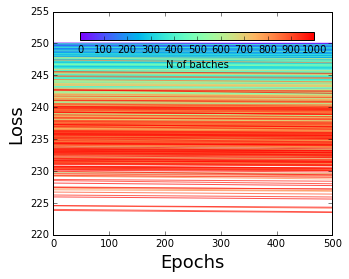

In [434]:
# Dispaly loss decreasing
fig = plt.figure(figsize=(5, 4))
cmap = cm.get_cmap('rainbow',Nbatch)
for i in Loss:
    epochs,loss=zip(*sorted(Loss[i]))
    plt.plot(epochs,loss,color=cmap(i),alpha=0.7)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Loss',fontsize=18)
ax1 = fig.add_axes([0.2, 0.8, 0.65, 0.03])
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=mpl.colors.Normalize(vmin=0, vmax=Nbatch),
                                orientation='horizontal')
cb1.set_label('N of batches')

In [435]:
index=Y.keys()[l:len(V)]
TestData=[]
for i in index:
    TestData.append(V[i].T.flatten())
TestData=np.array(TestData)
xTest = Variable(torch.from_numpy(TestData).type(dtype), requires_grad=False)
PredictData = xTest.mm(w1).clamp(min=0).mm(w2)
compare=np.argmax(PredictData.data.numpy(),axis=1)-np.array([Y[i] for i in index])
Accuracy=list(compare).count(0)/float(len(compare))
Accuracy

0.6171428571428571